In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_algorithms import VQE 
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import  QuantumCircuit 
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

## Generator Z-Matrix

In [3]:
def generate_zmatrix_Ne(num_H, num_Ne):
    zmatrix = []
    
    # Alternar H y Ne
    atoms = []
    h_count = 0
    ne_count = 0

    while h_count < num_H or ne_count < num_Ne:
        if h_count < num_H:
            atoms.append('H')
            h_count += 1
        if ne_count < num_Ne:
            atoms.append('Ne')
            ne_count += 1

    # Construir la Z-matrix
    if len(atoms) < 1:
        raise ValueError("Debe haber al menos un átomo.")

    zmatrix.append(f"{atoms[0]}")  # Primer átomo sin conexiones

    if len(atoms) >= 2:
        # Verificar si es H-Ne o no
        distance = 0.7 if ('H' in [atoms[0], atoms[1]] and 'Ne' in [atoms[0], atoms[1]]) else 1.5
        zmatrix.append(f"{atoms[1]} 1 {distance}")

    if len(atoms) >= 3:
        # Verificar tipo de enlace para 3er átomo
        distance = 0.7 if ('H' in [atoms[1], atoms[2]] and 'Ne' in [atoms[1], atoms[2]]) else 1.5
        zmatrix.append(f"{atoms[2]} 2 {distance} 1 109.5")

    for i in range(3, len(atoms)):
        # Verificar tipo de enlace
        distance = 0.7 if ('H' in [atoms[i-1], atoms[i]] and 'Ne' in [atoms[i-1], atoms[i]]) else 1.5
        zmatrix.append(f"{atoms[i]} {i} {distance} {i-1} 109.5 {i-2} 180.0")

    return zmatrix


def generate_zmatrix_He(num_H, num_Ne):
    zmatrix = []
    
    # Alternar H y Ne
    atoms = []
    h_count = 0
    ne_count = 0

    while h_count < num_H or ne_count < num_Ne:
        if h_count < num_H:
            atoms.append('H')
            h_count += 1
        if ne_count < num_Ne:
            atoms.append('He')
            ne_count += 1

    # Construir la Z-matrix
    if len(atoms) < 1:
        raise ValueError("Debe haber al menos un átomo.")

    zmatrix.append(f"{atoms[0]}")  # Primer átomo sin conexiones

    if len(atoms) >= 2:
        # Verificar si es H-Ne o no
        distance = 0.7 if ('H' in [atoms[0], atoms[1]] and 'He' in [atoms[0], atoms[1]]) else 1.5
        zmatrix.append(f"{atoms[1]} 1 {distance}")

    if len(atoms) >= 3:
        # Verificar tipo de enlace para 3er átomo
        distance = 0.7 if ('H' in [atoms[1], atoms[2]] and 'He' in [atoms[1], atoms[2]]) else 1.5
        zmatrix.append(f"{atoms[2]} 2 {distance} 1 109.5")

    for i in range(3, len(atoms)):
        # Verificar tipo de enlace
        distance = 0.7 if ('H' in [atoms[i-1], atoms[i]] and 'Ne' in [atoms[i-1], atoms[i]]) else 1.5
        zmatrix.append(f"{atoms[i]} {i} {distance} {i-1} 109.5 {i-2} 180.0")

    return zmatrix


## Hydrogen vs Neon

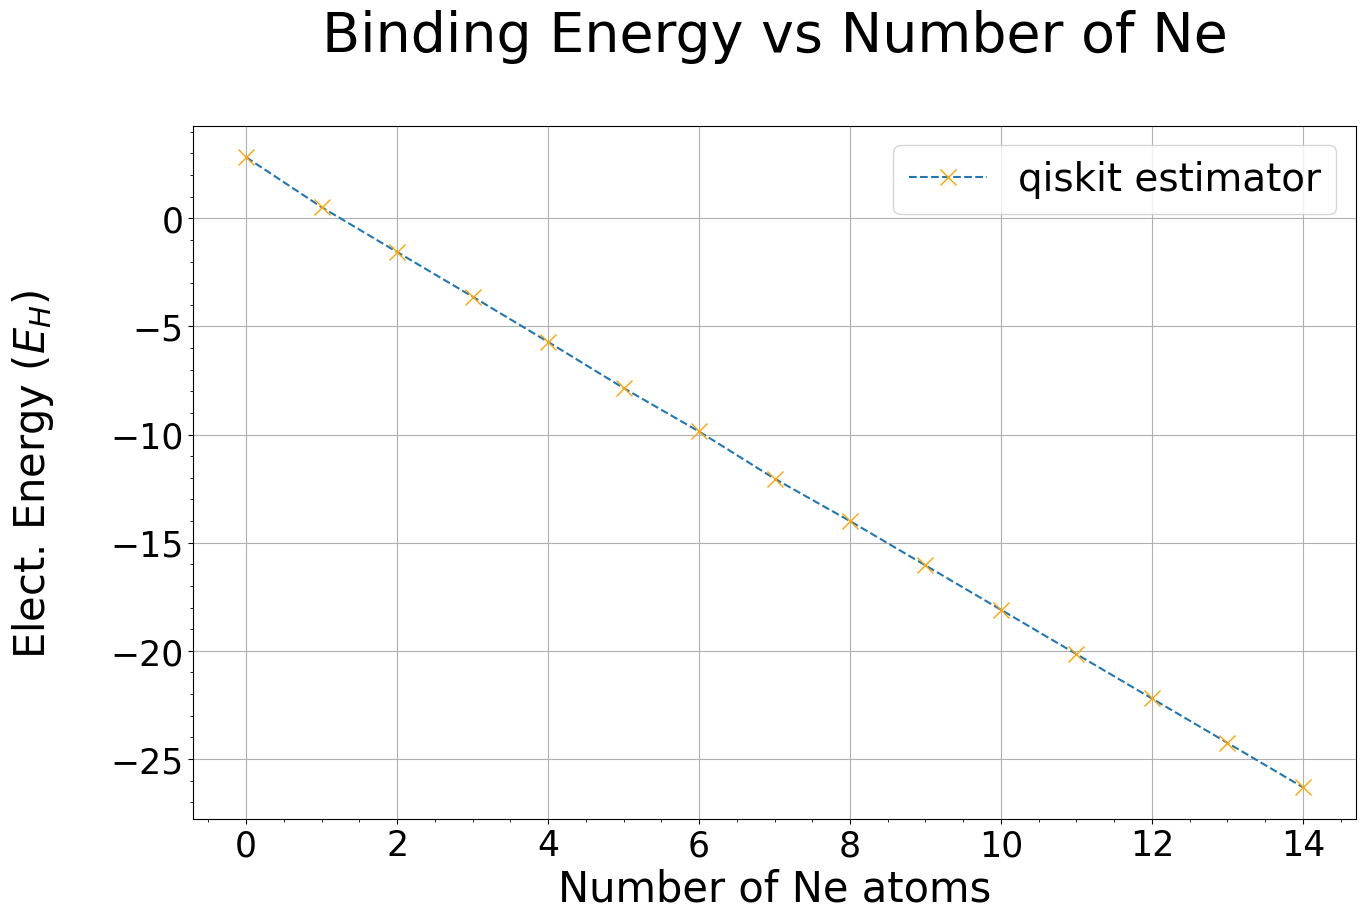

In [5]:
number_Ne = [i for i in range(15)]

H_separated = -0.5

Ne_separated = -128.547

energia_total = np.zeros(len(number_Ne))


for j, n in enumerate(number_Ne): 

    z_matrix= generate_zmatrix_Ne(8,n)

    # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
    driver = PySCFDriver(atom=z_matrix, basis="sto-3g") 
    problema = driver.run()
    # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
    # En este caso se considera que los obitales 4 y 5 estan no activos
    fc_transformer = ActiveSpaceTransformer(2, 2)

    problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

        #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    ansatz = UCCSD(problem.num_spatial_orbitals,
                problem.num_particles,
                mapper,
                initial_state=HartreeFock(
                    problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,),
    )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problem)
    
    diferences = -(result.total_energies[0] -(H_separated * 8 + Ne_separated * n))

    energia_total[j] = diferences

plt.figure(figsize=(15, 9))
plt.errorbar(number_Ne, energia_total, marker='x', linestyle='--', label='qiskit estimator', markeredgecolor='orange', markerfacecolor='orange', markersize=12)
plt.xlabel('Number of Ne atoms', fontsize=30)
plt.ylabel('Elect. Energy ($E_H$) \n', fontsize= 30)
plt.title('Binding Energy vs Number of Ne\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()


## Hydrogene vs Helium

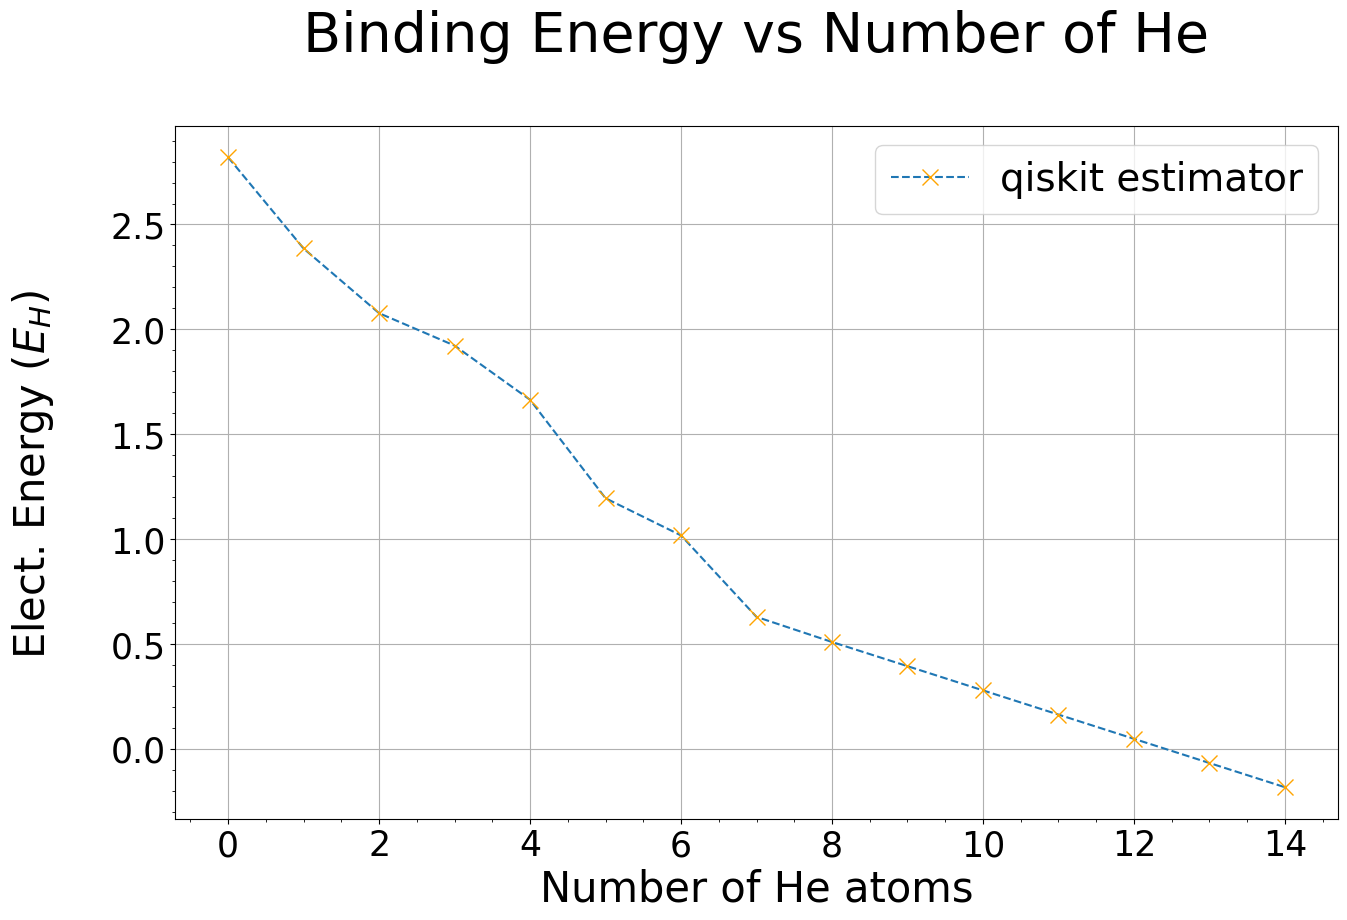

In [6]:
number_Ne = [i for i in range(15)]

H_separated = -0.5
He_separated = -2.9037
Ne_separated = -128.547

energia_total = np.zeros(len(number_Ne))


for j, n in enumerate(number_Ne): 

    z_matrix= generate_zmatrix_He(8,n)

    # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
    driver = PySCFDriver(atom=z_matrix, basis="sto-3g") 
    problema = driver.run()
    # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
    # En este caso se considera que los obitales 4 y 5 estan no activos
    fc_transformer = ActiveSpaceTransformer(2, 2)

    problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

        #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    ansatz = UCCSD(problem.num_spatial_orbitals,
                problem.num_particles,
                mapper,
                initial_state=HartreeFock(
                    problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,),
    )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problem)
    
    diferences = -(result.total_energies[0] -(H_separated * 8 + He_separated * n))

    energia_total[j] = diferences

plt.figure(figsize=(15, 9))
plt.errorbar(number_Ne, energia_total, marker='x', linestyle='--', label='qiskit estimator', markeredgecolor='orange', markerfacecolor='orange', markersize=12)
plt.xlabel('Number of He atoms', fontsize=30)
plt.ylabel('Elect. Energy ($E_H$) \n', fontsize= 30)
plt.title('Binding Energy vs Number of He\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

## Combination of He and Ne

In [7]:
def generate_zmatrix_H_He_Ne(num_H, num_He, num_Ne):
    zmatrix = []
    
    # Crear la lista de átomos según cantidades
    atoms = []
    h_count = 0
    he_count = 0
    ne_count = 0

    # Alternar agregando H, He, Ne mientras haya
    while h_count < num_H or he_count < num_He or ne_count < num_Ne:
        if h_count < num_H:
            atoms.append('H')
            h_count += 1
        if he_count < num_He:
            atoms.append('He')
            he_count += 1
        if ne_count < num_Ne:
            atoms.append('Ne')
            ne_count += 1

    # Construir la Z-matrix
    if len(atoms) < 1:
        raise ValueError("Debe haber al menos un átomo.")

    zmatrix.append(f"{atoms[0]}")  # Primer átomo (sin conexión)

    if len(atoms) >= 2:
        zmatrix.append(f"{atoms[1]} 1 1.0")  # Segundo átomo conectado al primero (distancia 1.0 Å)

    if len(atoms) >= 3:
        zmatrix.append(f"{atoms[2]} 2 1.5 1 109.5")  # Tercer átomo conectado al segundo, ángulo con el primero

    for i in range(3, len(atoms)):
        zmatrix.append(f"{atoms[i]} {i} 1.5 {i-1} 109.5 {i-2} 180.0")  # Siguientes conectados de manera simple

    return zmatrix


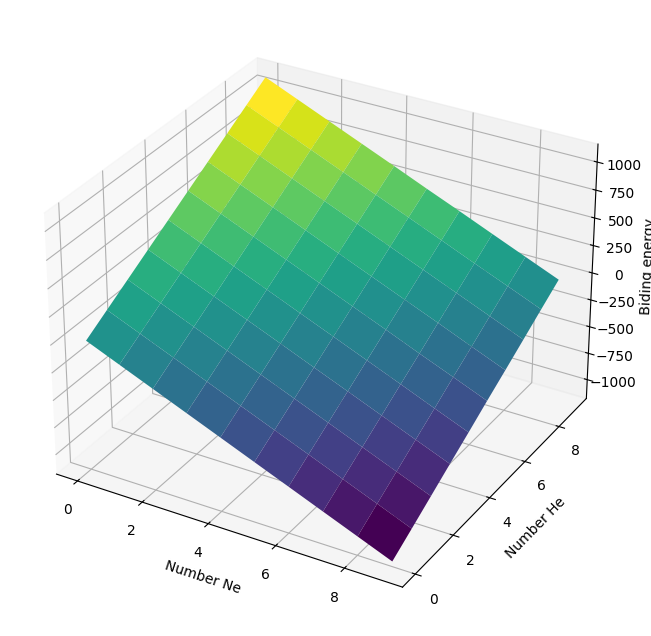

In [11]:
number_Ne = [i for i in range(10)]
number_He = [i for i in range(10)]
energia_total = np.zeros((len(number_He), len(number_Ne)))


for i in number_Ne:
    for j in number_He: 

        z_matrix= generate_zmatrix_H_He_Ne(8, i, j)

        # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
        driver = PySCFDriver(atom=z_matrix, basis="sto-3g") 
        problema = driver.run()

        # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
        # En este caso se considera que los obitales 4 y 5 estan no activos
        fc_transformer = ActiveSpaceTransformer(2, 2)

        problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

            #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
        mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

        ansatz = UCCSD(problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,
                    initial_state=HartreeFock(
                        problem.num_spatial_orbitals,
                        problem.num_particles,
                        mapper,),
        )
        vqe = VQE(Estimator(), ansatz, SLSQP())

        initial_point = HFInitialPoint()
        initial_point.ansatz = ansatz
        initial_point.problem = problem
        vqe.initial_point = initial_point.to_numpy_array()
        solver = GroundStateEigensolver(mapper, vqe)
        result = solver.solve(problem)

        energia_total[i,j] = (He_separated * j + Ne_separated * i + H_separated * 8) - result.total_energies[0]
        
        
# Generación del gráfico 3D
X, Y = np.meshgrid(number_Ne, number_He)
Z = energia_total.T  # Transpuesta para alinear correctamente los datos

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Number Ne')
ax.set_ylabel('Number He')
ax.set_zlabel('Biding energy')
plt.show()